In [556]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import os

import torch
from torch import nn, optim
from torchvision import transforms


import segmentation_models_pytorch as smp

from pathlib import Path

In [557]:
DATASET_FILEPATH = Path('set-lipstick-original/')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [558]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [559]:
df = pd.read_csv(LIST_CSV_FILEPATH)
df.head()

filename  width  height class  xmin  ymin  xmax  ymax  \
0  image00000001.jpg   1280     720  Lips   661   394   776   444   
1  image00000002.jpg   1280     720  Lips   557   336   682   392   
2  image00000003.jpg   1280     720  Lips   553   369   684   427   
3  image00000004.jpg   1280     720  Lips   555   351   681   408   
4  image00000005.jpg   1280     720  Lips   555   351   680   407   

               mask  
0  mask00000001.png  
1  mask00000002.png  
2  mask00000003.png  
3  mask00000004.png  
4  mask00000005.png

In [560]:
df = df[['filename', 'mask']]

In [561]:
print(len(df))

28594


In [562]:
list_img = []
for f in IMAGES_FILEPATH.iterdir():
    list_img.append(f)
    
list_mask = []
for f in MASKS_FILEPATH.iterdir():
    list_mask.append(f)

In [563]:
list_img = sorted(list_img)
list_mask = sorted(list_mask)

In [564]:
len(list_img), len(list_mask)

(28594, 28540)

In [565]:
df = df.loc[df['mask'].isin([i.name for i in list_mask])]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [566]:
filename = df['filename']
mask = df['mask']

In [567]:
img_filename = cv2.imread(os.path.join(IMAGES_FILEPATH, filename[0]))
img_filename = cv2.cvtColor(img_filename, cv2.COLOR_BGR2RGB)
img_filename = cv2.resize(img_filename, (256, 256))
img_filename = np.asarray(img_filename).astype('float')
img_filename = torch.as_tensor(img_filename) / 255.0
img_filename = img_filename.permute(2, 0, 1)

In [568]:
img_mask = cv2.imread(os.path.join(MASKS_FILEPATH, mask[0]))
img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
img_mask = cv2.resize(img_mask, (256, 256))
img_mask = np.asarray(img_mask).astype('float')
img_mask = torch.as_tensor(img_mask) / 255.0
img_mask = img_mask.permute(2, 0, 1)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


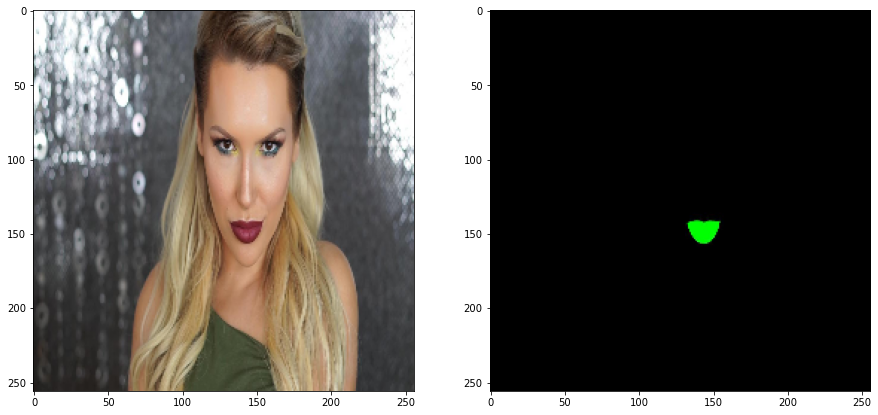

In [569]:
print(img_filename.shape, img_mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img_filename.permute(1, 2, 0))
ax[1].imshow(img_mask.permute(1, 2, 0))
plt.show()

In [570]:
class MyDataset(torch.utils.data.Dataset):
   
    def __init__(self, data):
        
        self.data = data
        
        
        self.data_filename = data['filename']
        self.data_mask = data['mask']

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, idx):
        
        data = self.data.iloc[idx]
        
        img_filename = cv2.imread(os.path.join(IMAGES_FILEPATH, data['filename']))
        img_filename = cv2.cvtColor(img_filename, cv2.COLOR_BGR2RGB)
        img_filename = cv2.resize(img_filename, (256, 256))
        img_filename = np.asarray(img_filename).astype('float')
        img_filename = torch.as_tensor(img_filename) / 255.0
        img_filename = img_filename.permute(2, 0, 1)
        
        img_mask = cv2.imread(os.path.join(MASKS_FILEPATH, data['mask']))
        img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
        img_mask = cv2.resize(img_mask, (256, 256))
        img_mask = np.asarray(img_mask).astype('float')
        img_mask = torch.as_tensor(img_mask) / 255.0
        img_mask = img_mask.permute(2, 0, 1)
        
        return img_filename.float(), img_mask

In [571]:
train_dataset, valid_dataset = train_test_split(df, test_size=0.5, random_state=42)

In [572]:
train_dataset = MyDataset(train_dataset)
valid_dataset = MyDataset(valid_dataset)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


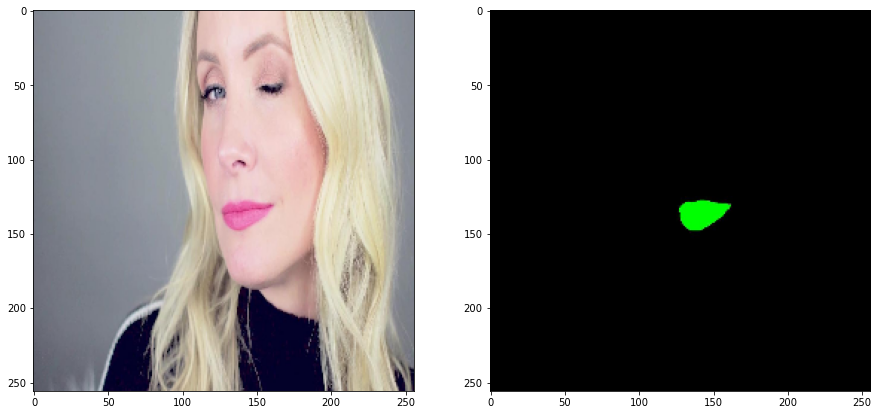

In [573]:
img_filename, img_mask = train_dataset[2]
print(img_filename.shape, img_mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img_filename.permute(1, 2, 0))
ax[1].imshow(img_mask.permute(1, 2, 0))
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                              batch_size=124,
                              shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                              batch_size=64,
                              shuffle=False)

torch.Size([24, 3, 256, 256]) torch.Size([24, 3, 256, 256])
tensor(0.) tensor(1.)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


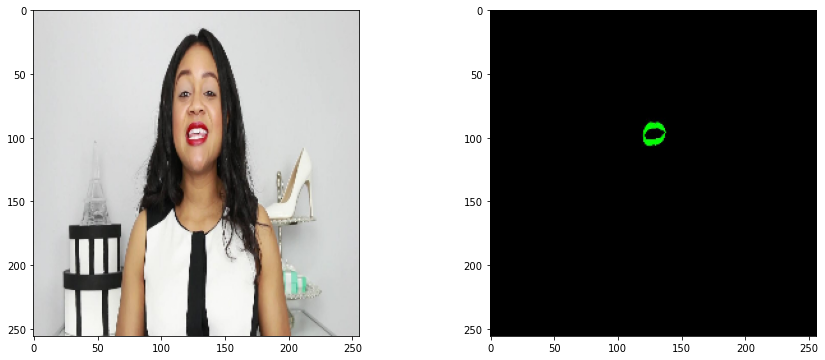

In [582]:
for img_filename, img_mask in train_loader:
    print(img_filename.shape, img_mask.shape)
    print(img_filename[0].min(), img_filename[0].max())
    print(img_mask[0].min(), img_mask[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img_filename[0].permute(1, 2, 0))
    ax[1].imshow(img_mask[0].permute(1, 2, 0))
    break

In [583]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [584]:
model = smp.Linknet(encoder_name='resnet50', 
               encoder_weights='imagenet', 
               classes=1,
               activation='sigmoid').to(device)

In [585]:
import segmentation_models_pytorch.utils as smp_utils

In [586]:
criterion = smp_utils.losses.DiceLoss()
metric = [smp_utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)

In [587]:
train_epoch = smp_utils.train.TrainEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         optimizer=optimizer, 
                                         device=device, 
                                         verbose=True)

valid_epoch = smp_utils.train.ValidEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         device=device)

In [588]:
for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

Epoch: 1
train: 100%|█| 595/595 [2:54:52<00:00, 17.63s/it, dice_loss - 0.2374, iou_score 
valid: 100%|█| 1784/1784 [14:54<00:00,  1.99it/s, dice_loss - 0.0937, iou_score 


In [589]:
data_iter = iter(train_loader)

In [590]:
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)

/var/folders/9q/dsjswm2x2q9_rxvxgvcvbqk00000gn/T/ipykernel_10924/3177176282.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))


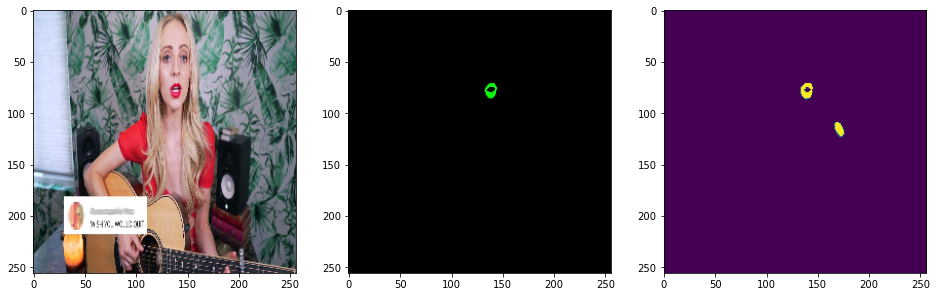

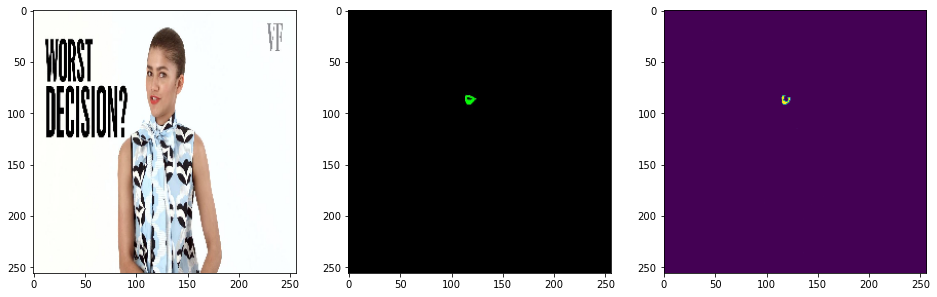

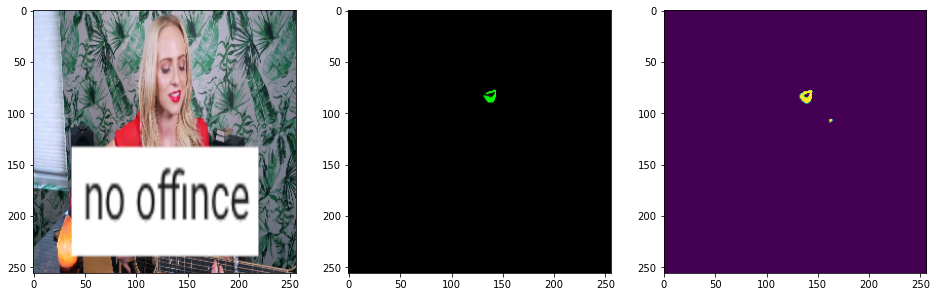

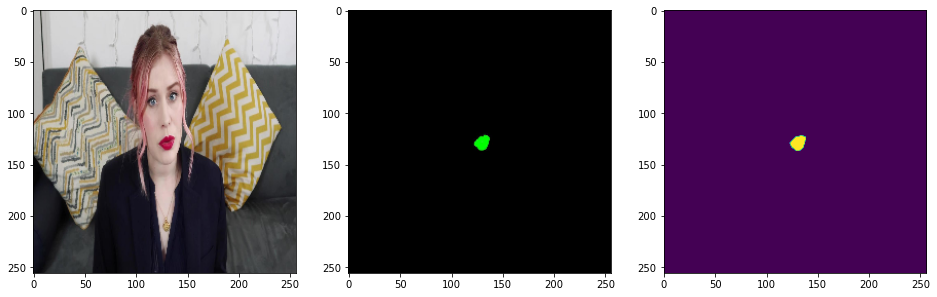

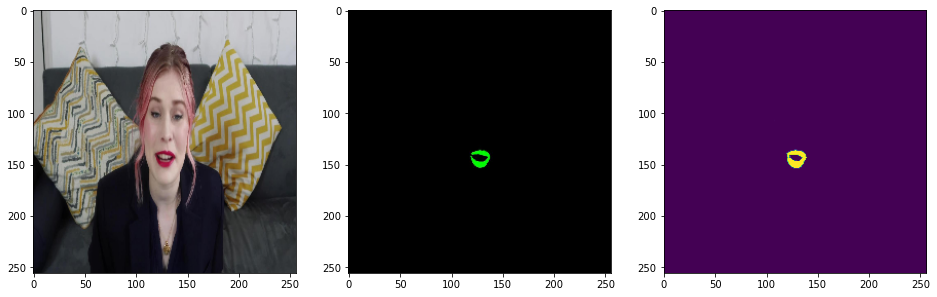

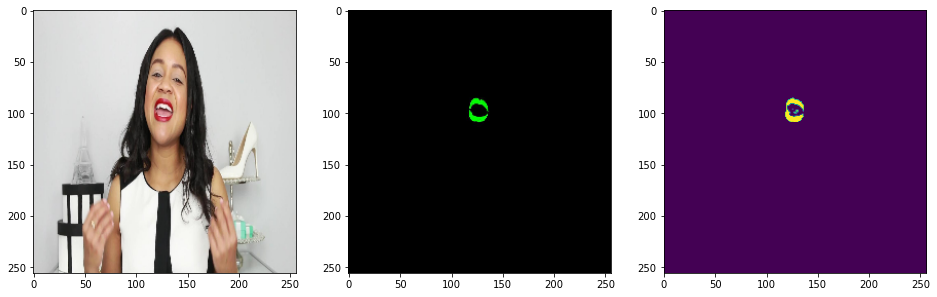

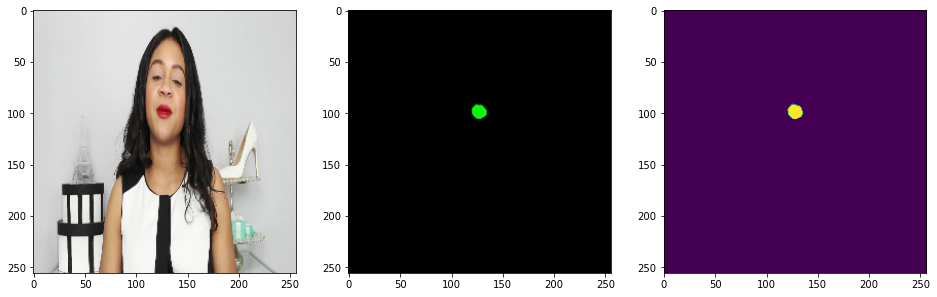

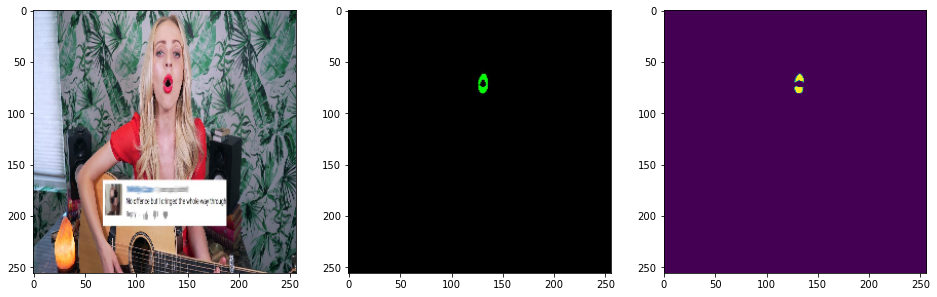

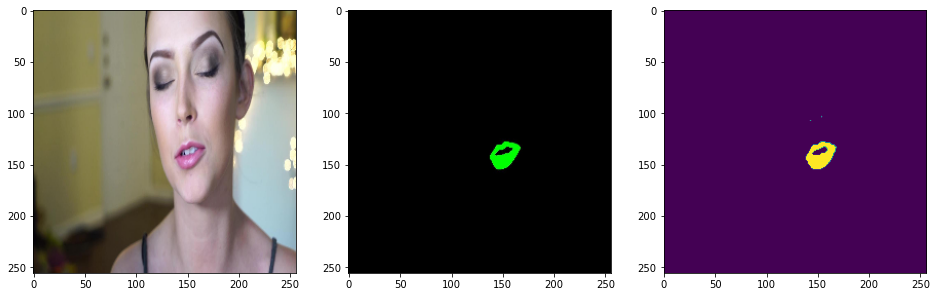

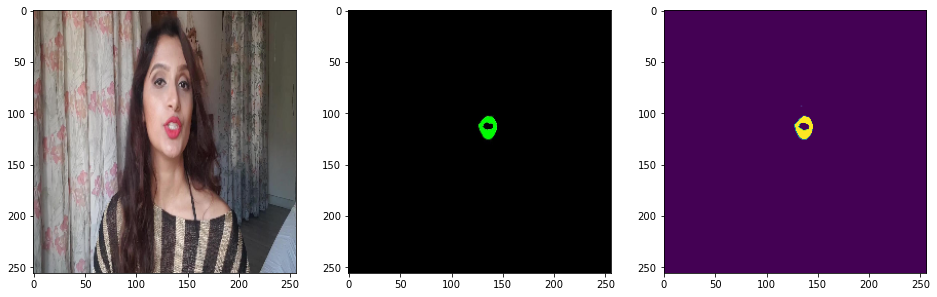

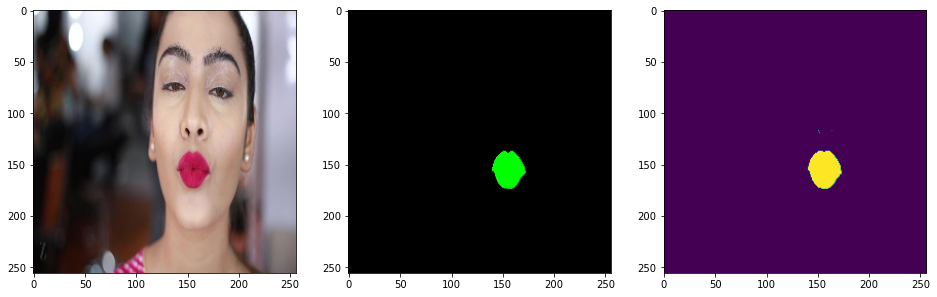

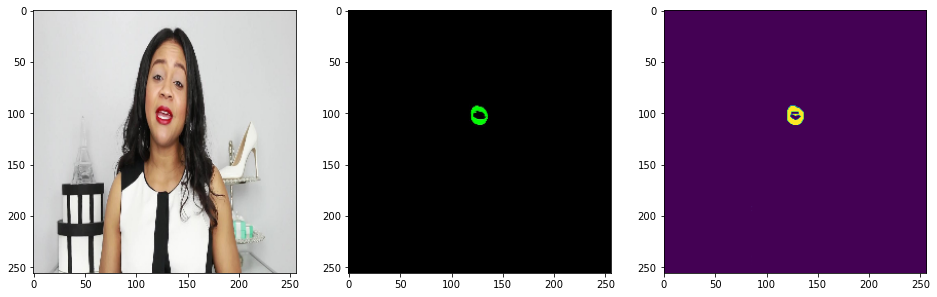

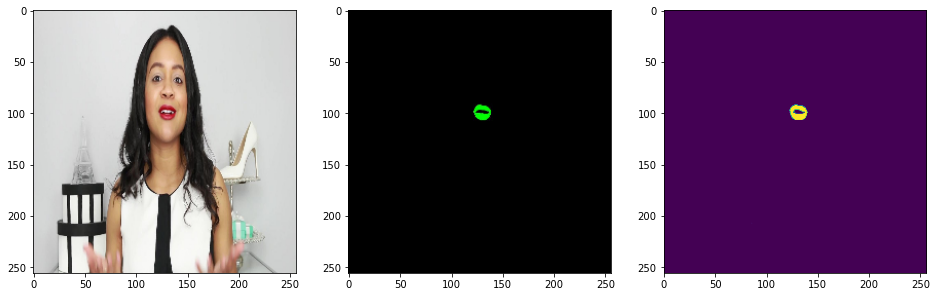

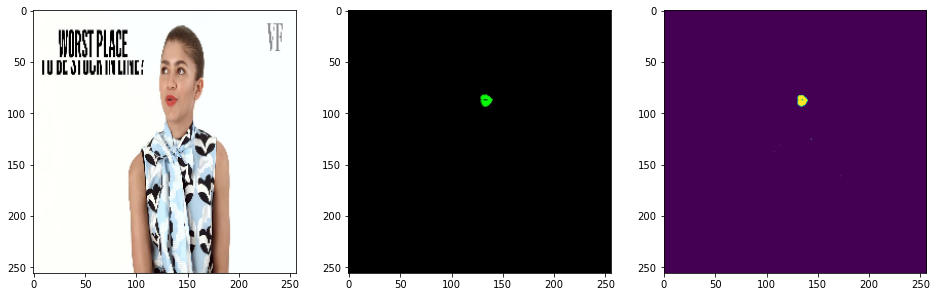

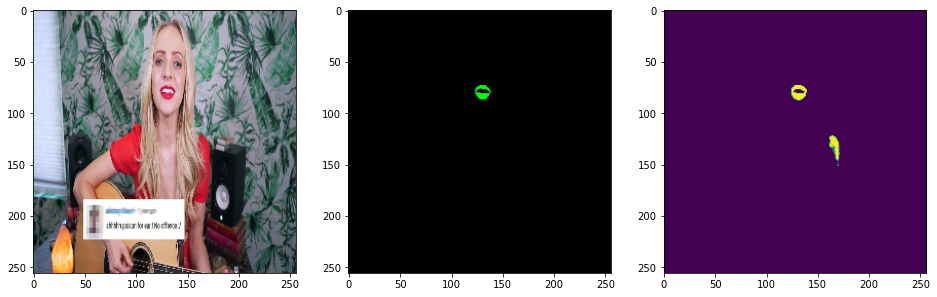

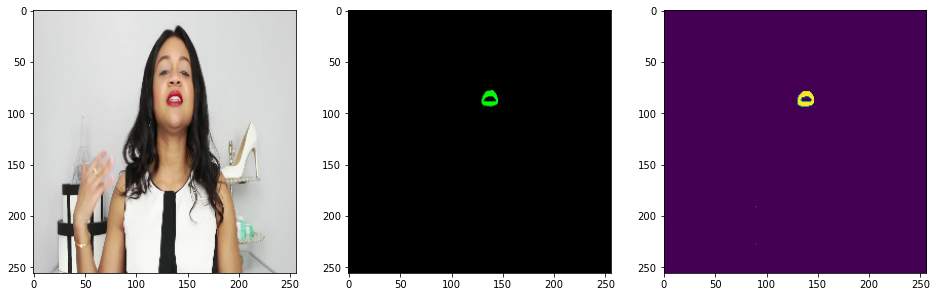

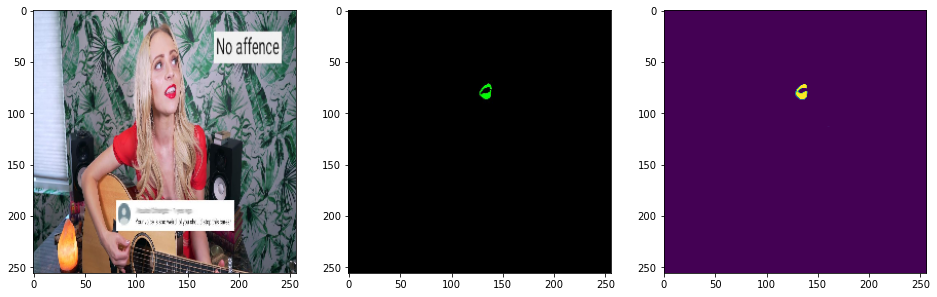

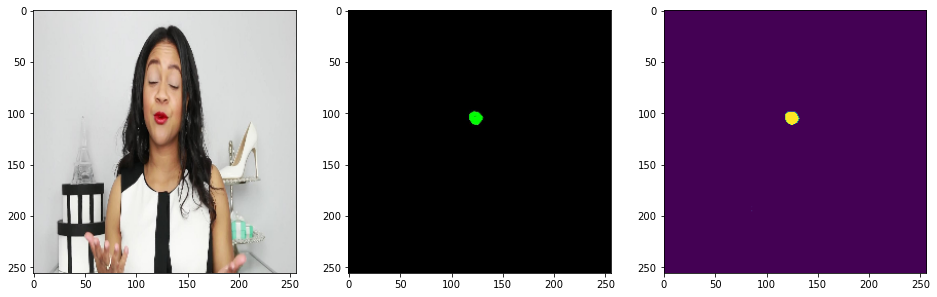

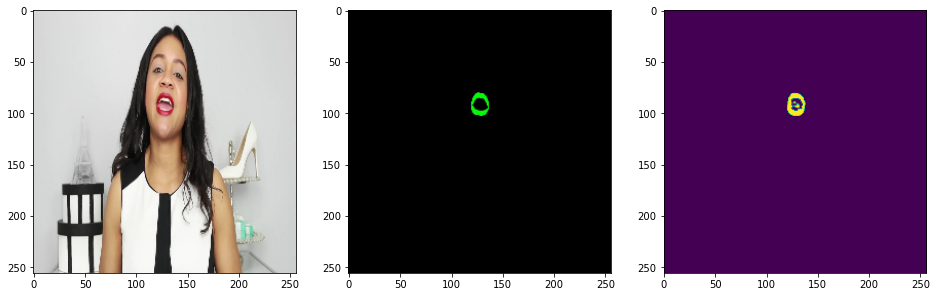

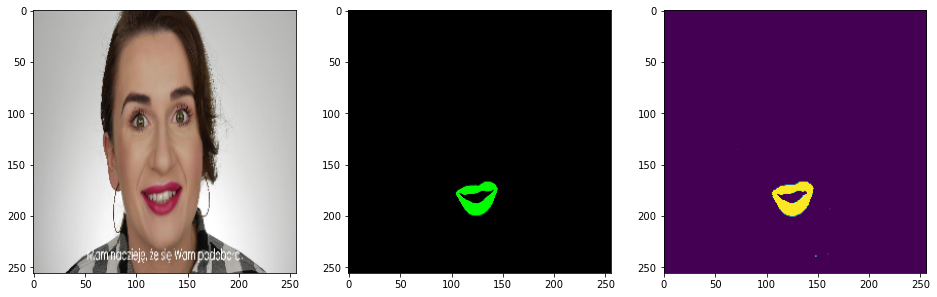

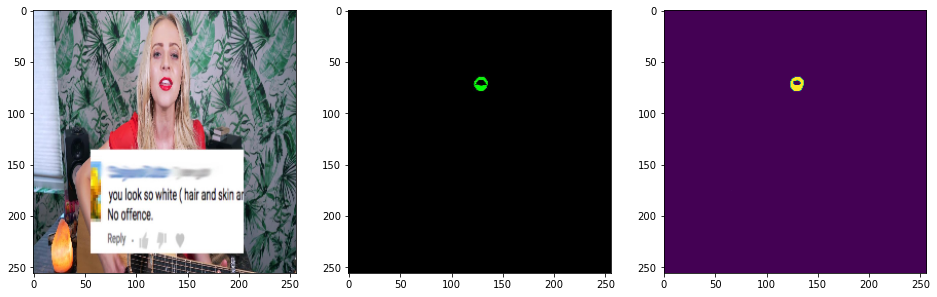

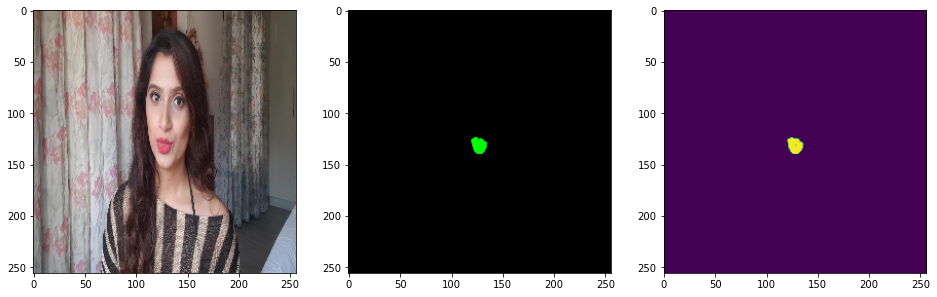

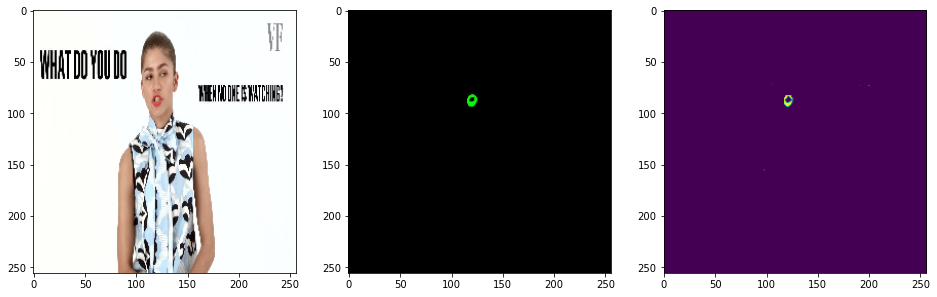

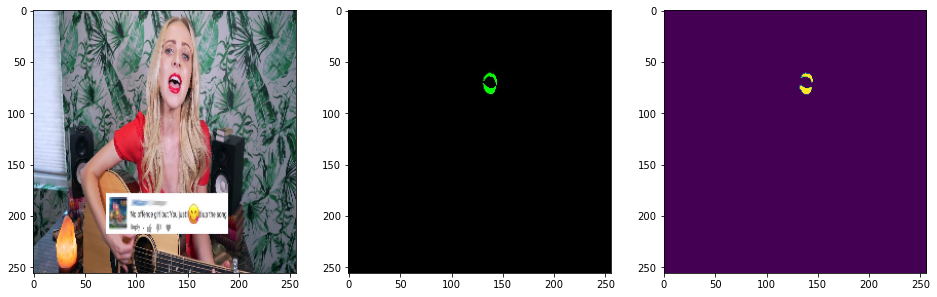

In [592]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu()) 
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))  
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))